# Project 3: Reddit data scraping

## Part 2 - Data Cleaning and Basic EDA

In [1]:
# General imports
import pandas as pd
import seaborn as sns
import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt
import pickle

# For Natural Language Processing
import regex as re
import unidecode
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# For Classification Modeling
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

# For Evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix, plot_roc_curve, roc_auc_score, classification_report

/Users/ericrodriguez/opt/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# Read in both subreddit datasets
mental_df = pd.read_csv('../data/mentalhealth_211001_171956.csv', encoding = 'utf-8')
covid_df = pd.read_csv('../data/CoronavirusUS_211001_172844.csv', encoding = 'utf-8')

# Combine into single dataframe
df = pd.concat([mental_df, covid_df])
df = df.reset_index(drop=True)
df['is_mental'] = df['subreddit'].map(lambda t: 1 if t == 'mentalhealth' else 0)

In [3]:
# View the shape
df.shape

(3999, 10)

In [4]:
# Check datatypes 
df.dtypes

created_utc      int64
url             object
full_link       object
id              object
num_comments     int64
title           object
selftext        object
subreddit       object
timestamp       object
is_mental        int64
dtype: object

In [5]:
# Check for nulls
df.isnull().sum()

created_utc        0
url                0
full_link          0
id                 0
num_comments       0
title              0
selftext        1244
subreddit          0
timestamp          0
is_mental          0
dtype: int64

There is 1244 null cells in the "selftext" column

In [6]:
# Check the number of missing nulls by subreddit group
df['selftext'].isnull().groupby(df['is_mental']).sum()

is_mental
0    1226
1      18
Name: selftext, dtype: int64

It is clear here that there are more missing selftext values in the r/CoronavirusUS subreddit than in the r/mentalhealth subreddit.

After scanning through the data, there is evidence of [removed] and [deleted] values in the selftext
There is also links to other articles which starts with [http], which will need to be cleaned

In [7]:
# View titles from r/mentalhealth
df.loc[df['is_mental'] ==1, 'title'].head(20)

0     Has anyone else been completely unable to moni...
1     Is it normal to cry when you see someone you love
2                                 Somethings gotta give
3                                      Train Your Brain
4                                         Rage attacks?
5                                     I have a Question
6     Taking off of work once a month because of maj...
7                               I can't do this anymore
8     I have an irrational fear of a "trope" in fict...
9     My old friends from school are anxiety trigger...
10    Does this count as an ED? If so, is there a pr...
11                   Why dont I feel sad after a death.
12    if i no longer live in a toxic environment, wh...
13                                         Hopelessness
14          What are the best things for mental health?
15          Complex PTSD and in-patient hospitalization
16                               Am I Really Depressed?
17                                Am I self-sabo

In [8]:
# View titles from r/CoronavirusUS
df.loc[df['is_mental'] == 0, 'title'].head(20)

2000    Doubling Up Masks Creates ‘Obstacle Course’ Fo...
2001                                    Covid 19 sweating
2002    COVID-19 2021 - How to stay safe from COVID-19...
2003        64% of Doomers Don’t Believe Fauci Said This:
2004    Nearly 12,000 doses of Moderna COVID-19 vaccin...
2005    Whitmer: It will take 2 years to get 70% of Mi...
2006                                          Frustrated!
2007    Now, within his first 100 days in office, Pres...
2008    [OC] Top Countries by Number of Covid-19 Vacci...
2009    I don’t think I’ll ever be able to forgive people
2010    Will the vaccine be less effective in stopping...
2011                         Contact traced for no reason
2012    400,000 Americans have died of COVID-19. As a ...
2013    Amazon offers to help Biden administration wit...
2014    About 4.2% of the US population have received ...
2015    COVID19 can affect people of all ages! [Research]
2016    Need a COVID test? Four South Florida malls wi...
2017    Can so

First 15 examples of r/CoronavirusUS contain language that could be applicable to mental health issues

Both subreddits contain examples of unnecessary capital lettering

Curious to see what mental health words are contained in both datasets

Curious to see if for what the model misclassifies, if the misclassified post is related to the subreddit it gets classified into (ie. a post on r/mentalhealth is classified as r/CoronavirusUS due to it including the word COVID)

What happens when I use covid-19 or pandemic as a stop word? Would that make sense? What would I be showing there?

Calculate most popular words and remove them as stop words

In [9]:
# Check for duplicate and empty non-NaN titles
df.title.value_counts()

AIs from AI Dungeon 2 to sexy to funny and one based wholly on Reddit!    9
I need help                                                               6
Antihistamines may protect against the coronavirus                        4
What is wrong with me?                                                    3
I have a question                                                         3
                                                                         ..
I feel like I’m literally forgetting myself                               1
How do I motivate myself to do things?                                    1
Feeling worthless all the time                                            1
My boyfriend is being mean to me and blaming it on "his other self".      1
COVID-19 vaccines work well against California variant, scientists say    1
Name: title, Length: 3931, dtype: int64

In [10]:
# Check for duplicate and empty non-NaN selftext values
df.selftext.value_counts()

[removed]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [11]:
# Check for duplicate values
df['title'].duplicated().value_counts()

False    3931
True       68
Name: title, dtype: int64

There are 68 duplicate titles

In [12]:
# Verify distrubtion
df.subreddit.value_counts(normalize=True)

mentalhealth     0.500125
CoronavirusUS    0.499875
Name: subreddit, dtype: float64

## 2. Preprocessing
**Going to start by cleaning my data, aand then I'm going to Integrate and Transform my data**

1. convert missing and deleted to NaN
2. Delete duplicates titles
3. Find most popular words and most common words
4. Vectorize and do stop words
6. Do another sentiment analysis (by sentence,by word?)
6. Drop 1 letter titles (the inapp. post)

In [13]:
# Replace '[removed]' with NaN in the 'selftext' column
df['selftext'] = df['selftext'].replace({'[removed]': np.nan})

In [14]:
# Replace '[deleted]' with NaN in the 'selftext' column
df['selftext'] = df['selftext'].replace({'[deleted]': np.nan})

In [15]:
# Drop duplicates based on title column
df = df.drop_duplicates(subset='title')

In [16]:
# Check for duplicate values
df['title'].duplicated().value_counts()

False    3931
Name: title, dtype: int64

In [17]:
# Remove hyperlinks from title and selftext
df['title'] = df['title'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])
df['selftext'] = df['selftext'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])

# Figure out proper code that avoids this warning! 
- also, what does drop duplicates do when there are NaNs?
- also, how do I get all value counts to make sure I'm not missing duplicates

In [18]:
# This shows I need to address values that are "[", ".", and I need to fill empty cells with NaN
df.selftext.value_counts()

nan                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [19]:
for x in df['title']:
    if len(x) < 3:
        print(x)

🤔
R
E
G
I
N


In [20]:
# MAKE SURE TO THROW THIS HIGHER UP, AND BEFORE YOU DELETE BAD WORD AND EMOJI
df.reset_index(inplace = True)

In [21]:
# index to drop are 3403, 3439 - 3443

In [22]:
df.loc[df['title'] == '🤔']
df.loc[df['title'] == "N"]

,index,created_utc,url,full_link,id,num_comments,title,selftext,subreddit,timestamp,is_mental
3443,3498,1615674983,https://www.reddit.com/r/CoronavirusUS/comment...,https://www.reddit.com/r/CoronavirusUS/comment...,m4hata,0,N,nan,CoronavirusUS,2021-03-13 17:36:23,0


In [23]:
# found innappropriate or emojis, dropping them
df = df.drop(df.index[[3403, 3439, 3440, 3441, 3442, 3443]])

In [24]:
len(df)

3925

In [25]:
# Reset index again
df.reset_index(inplace = True)

In [26]:
# Replacing "[" and "." and empty cells with NaN in the 'selftext' column
df['selftext'] = df['selftext'].replace({'[': np.nan})
df['selftext'] = df['selftext'].replace({'.': np.nan})
df['selftext'] = df['selftext'].replace({'': np.nan})

In [27]:
# Create a column for title character length
df['title_char_length'] = df['title'].apply(len)

# Create a column for title word count
df['title_word_count'] = df['title'].map(lambda x: len(x.split()))

df.head()

,level_0,index,created_utc,url,full_link,id,num_comments,title,selftext,subreddit,timestamp,is_mental,title_char_length,title_word_count
0,0,0,1611140689,https://www.reddit.com/r/mentalhealth/comments...,https://www.reddit.com/r/mentalhealth/comments...,l172x7,3,Has anyone else been completely unable to moni...,I had a psychotic break which seemed to come o...,mentalhealth,2021-01-20 06:04:49,1,70,11
1,1,1,1611140753,https://www.reddit.com/r/mentalhealth/comments...,https://www.reddit.com/r/mentalhealth/comments...,l173gi,7,Is it normal to cry when you see someone you love,I know this sounds weird but i guess let me ex...,mentalhealth,2021-01-20 06:05:53,1,49,11
2,2,2,1611141523,https://www.reddit.com/r/mentalhealth/comments...,https://www.reddit.com/r/mentalhealth/comments...,l179ft,2,Somethings gotta give,Been living with my mom who has bad mental iss...,mentalhealth,2021-01-20 06:18:43,1,21,3
3,3,3,1611141801,https://www.reddit.com/r/mentalhealth/comments...,https://www.reddit.com/r/mentalhealth/comments...,l17bmq,2,Train Your Brain,NaN,mentalhealth,2021-01-20 06:23:21,1,16,3
4,4,4,1611143753,https://www.reddit.com/r/mentalhealth/comments...,https://www.reddit.com/r/mentalhealth/comments...,l17rke,3,Rage attacks?,Hello. \nI usually talk to myself (and Im pret...,mentalhealth,2021-01-20 06:55:53,1,13,2


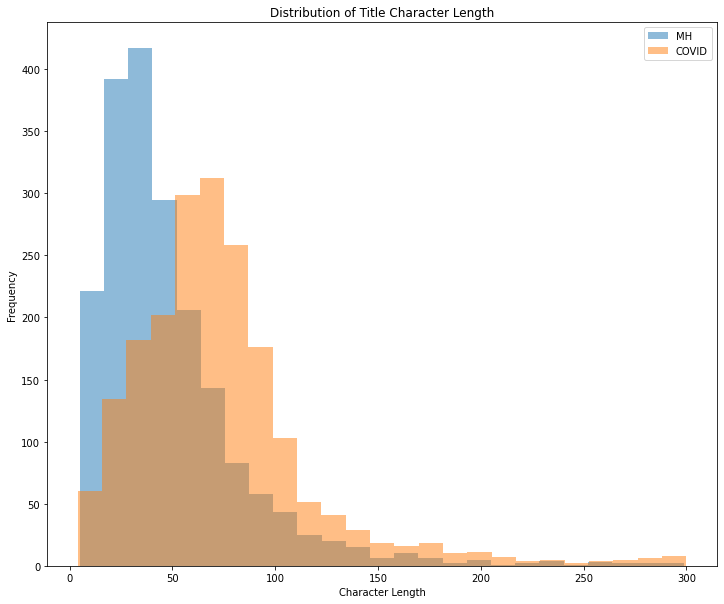

In [29]:
# Histogram of title character length
plt.figure(figsize=(12,10))
plt.title('Distribution of Title Character Length')
plt.xlabel('Character Length')
plt.ylabel('Frequency')
plt.hist(x=df[df['is_mental']==1]['title_char_length'],
         bins=25, alpha=0.5, label='MH')
plt.hist(x=df[df['is_mental']==0]['title_char_length'],
         bins=25, alpha=0.5, label='COVID')
plt.legend();

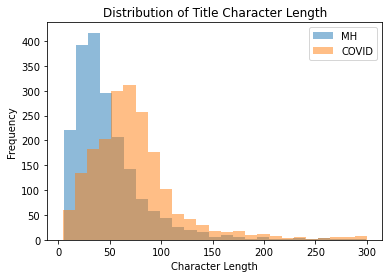

In [35]:
# Histogram of title character length
plt.title('Distribution of Title Character Length')
plt.xlabel('Character Length')
plt.ylabel('Frequency')
plt.hist(x=df[df['is_mental']==1]['title_char_length'],
         bins=25, alpha=0.5, label='MH')
plt.hist(x=df[df['is_mental']==0]['title_char_length'],
         bins=25, alpha=0.5, label='COVID')
plt.legend();

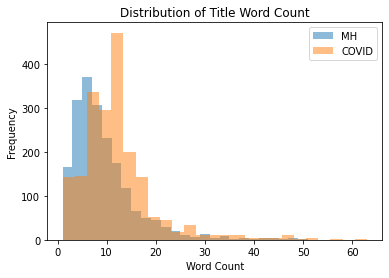

In [36]:
# Histogram of title word count
plt.title('Distribution of Title Word Count')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.hist(x=df[df['is_mental']==1]['title_word_count'],
         bins=25, alpha=0.5, label='MH')
plt.hist(x=df[df['is_mental']==0]['title_word_count'],
         bins=25, alpha=0.5, label='COVID')
plt.legend();

Out of curiousity, I'm going to check the sentiment of my posts

In [37]:
# Instantiate sentiment intesnity analyzer
sia = SentimentIntensityAnalyzer()

# create a column for the negative, neutral, positive, and compound analysis scores:
df['sentiment_comp'] = df['title'].map(lambda x: sia.polarity_scores(x)['compound'])
df['sentiment_neg'] = df['title'].map(lambda x: sia.polarity_scores(x)['neg'])
df['sentiment_neu'] = df['title'].map(lambda x: sia.polarity_scores(x)['neu'])
df['sentiment_pos'] = df['title'].map(lambda x: sia.polarity_scores(x)['pos'])

# Check code execution
df.head(3)

,level_0,index,created_utc,url,full_link,id,num_comments,title,selftext,subreddit,timestamp,is_mental,title_char_length,title_word_count,sentiment_comp,sentiment_neg,sentiment_neu,sentiment_pos
0,0,0,1611140689,https://www.reddit.com/r/mentalhealth/comments...,https://www.reddit.com/r/mentalhealth/comments...,l172x7,3,Has anyone else been completely unable to moni...,I had a psychotic break which seemed to come o...,mentalhealth,2021-01-20 06:04:49,1,70,11,0.0000,0.00,1.000,0.000
1,1,1,1611140753,https://www.reddit.com/r/mentalhealth/comments...,https://www.reddit.com/r/mentalhealth/comments...,l173gi,7,Is it normal to cry when you see someone you love,I know this sounds weird but i guess let me ex...,mentalhealth,2021-01-20 06:05:53,1,49,11,0.2732,0.19,0.552,0.258
2,2,2,1611141523,https://www.reddit.com/r/mentalhealth/comments...,https://www.reddit.com/r/mentalhealth/comments...,l179ft,2,Somethings gotta give,Been living with my mom who has bad mental iss...,mentalhealth,2021-01-20 06:18:43,1,21,3,0.0000,0.00,1.000,0.000


In [38]:
# Average sentiment of r/mentalhealth
print(df[df['is_mental']==1][['sentiment_comp']].mean())
print(df[df['is_mental']==1][['sentiment_neg']].mean())
print(df[df['is_mental']==1][['sentiment_neu']].mean())
print(df[df['is_mental']==1][['sentiment_pos']].mean())

sentiment_comp   -0.109791
dtype: float64
sentiment_neg    0.196247
dtype: float64
sentiment_neu    0.690436
dtype: float64
sentiment_pos    0.11332
dtype: float64


In [39]:
# Average sentiment of r/CoronavirusUS
print(df[df['is_mental']==0][['sentiment_comp']].mean())
print(df[df['is_mental']==0][['sentiment_neg']].mean())
print(df[df['is_mental']==0][['sentiment_neu']].mean())
print(df[df['is_mental']==0][['sentiment_pos']].mean())

sentiment_comp    0.006475
dtype: float64
sentiment_neg    0.072777
dtype: float64
sentiment_neu    0.853274
dtype: float64
sentiment_pos    0.073945
dtype: float64


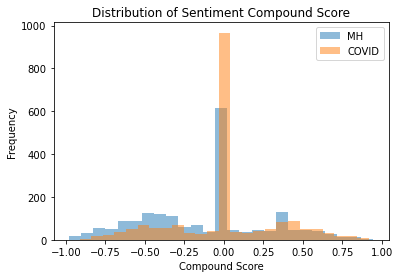

In [40]:
# Histogram of sentiment compound score
plt.title('Distribution of Sentiment Compound Score')
plt.xlabel('Compound Score')
plt.ylabel('Frequency')
plt.hist(x=df[df['is_mental']==1]['sentiment_comp'],
         bins=25, alpha=0.5, label='MH')
plt.hist(x=df[df['is_mental']==0]['sentiment_comp'],
         bins=25, alpha=0.5, label='COVID')
plt.legend();

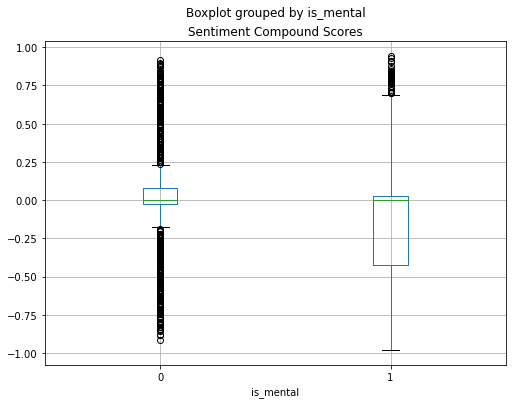

In [41]:
# Boxplot for sentiment compound scores
df.boxplot('sentiment_comp', by='is_mental', figsize=(8,6))
plt.title('Sentiment Compound Scores');

# Add Legend or better labels
This shows how the mentalhealth subreddit is largely negative with several positive outliers, whereas the coronavirus subreddit is interpetted as being alrgely neutral

In [42]:
# Count the most commonly used words for r/mentalhealth

# Define X
X = df[df['is_mental']==1]['title']

# Instantiate a CV object
cv = CountVectorizer(stop_words='english')

# Fit the CV on posts
cv.fit(X)

# Transform data
X_cv = cv.transform(X)

# Convert to a dataframe
cv_df = pd.DataFrame(X_cv.todense(),columns=cv.get_feature_names())

# Create a mh dataframe containing the 100 most common words and word count
mh_cv_df = pd.DataFrame(data=cv_df.sum().sort_values(ascending=False).head(100),
                        columns=['word_count'])

# Change index to a column
mh_cv_df.reset_index(inplace=True)
mh_cv_df = mh_cv_df.rename(columns={'index':'word'})

# Save wsb_cv_df to csv
mh_cv_df.to_csv('../data/mh_words.csv', index=False)

# Check code execution
mh_cv_df.head()

,word,word_count
0,help,157
1,mental,154
2,feel,152
3,don,126
4,like,112


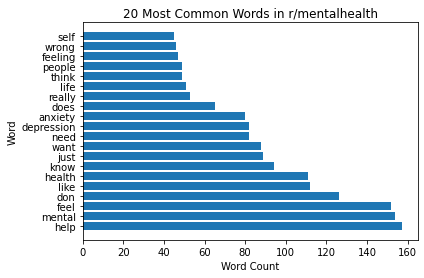

In [43]:
# Bar chart of the 20 most commonly seen words in r/mentalhealth
plt.barh(y=mh_cv_df['word'].head(20), width=mh_cv_df['word_count'].head(20))
plt.title('20 Most Common Words in r/mentalhealth')
plt.xlabel('Word Count')
plt.ylabel('Word');

In [44]:
# Count the most commonly used words for r/CoronavirusUS

# Define X
X = df[df['is_mental']==0]['title']

# Instantiate a CV object
cv = CountVectorizer(stop_words='english')

# Fit the CV on posts
cv.fit(X)

# Transform data
X_cv = cv.transform(X)

# Convert to a dataframe
cv_df = pd.DataFrame(X_cv.todense(),columns=cv.get_feature_names())

# Create a mh dataframe containing the 100 most common words and word count
covid_cv_df = pd.DataFrame(data=cv_df.sum().sort_values(ascending=False).head(100),
                        columns=['word_count'])

# Change index to a column
covid_cv_df.reset_index(inplace=True)
covid_cv_df = covid_cv_df.rename(columns={'index':'word'})

# Save wsb_cv_df to csv
covid_cv_df.to_csv('../data/covid_words.csv', index=False)

# Check code execution
covid_cv_df.head()

,word,word_count
0,covid,779
1,19,475
2,vaccine,450
3,coronavirus,157
4,new,134


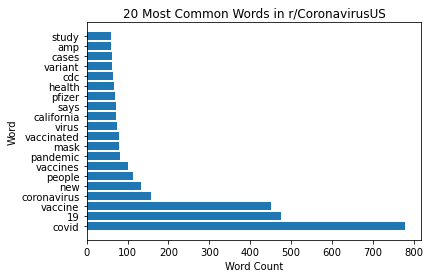

In [45]:
# Bar chart of the 20 most commonly seen words in r/CoronavirusUS
plt.barh(y=covid_cv_df['word'].head(20), width=covid_cv_df['word_count'].head(20))
plt.title('20 Most Common Words in r/CoronavirusUS')
plt.xlabel('Word Count')
plt.ylabel('Word');

In [46]:
# Find matches for the 100 most common words in both subreddits
common_words = []
for word in mh_cv_df['word']:
    if word in list(covid_cv_df['word']):
        common_words.append(word)
print(len(common_words))
print(common_words)

24
['help', 'don', 'like', 'health', 'know', 'just', 'need', 'does', 'life', 'people', 'time', 'going', 'getting', 'day', 've', 'today', 'right', 'new', 'long', 'got', 'amp', 'best', 'say', 'question']


Interpretation: Of the 100 most commonly found words in the WSB and SSB subreddits, 41 words are shared between the two. A 41% match is high and indicates that a lot of terminology is common to users of both subreddits. This may limit the accuracy of any predictive models built to distinguish the two subreddits.

In [47]:
common_words_df = pd.DataFrame(data = common_words, columns = ['shared_word'])
common_words_df.head()

,shared_word
0,help
1,don
2,like
3,health
4,know


In [48]:
# Create a dictionary for r/mentalhealth shared word count
mh_shared_word_count = {}
for word in common_words_df['shared_word']:
    index = 0
    for i in mh_cv_df['word']:
        if word == i:
            mh_shared_word_count[word] = mh_cv_df['word_count'][index]
        index += 1

In [49]:
# Create a new column with r/mentalhealth word count
common_words_df['mh_word_count'] = common_words_df['shared_word'].map(mh_shared_word_count)

common_words_df.head()

,shared_word,mh_word_count
0,help,157
1,don,126
2,like,112
3,health,111
4,know,94


In [50]:
# Create a dictionary for r/CoronavirusUS shared word count
covid_shared_word_count = {}
for word in common_words_df['shared_word']:
    index = 0
    for i in covid_cv_df['word']:
        if word == i:
            covid_shared_word_count[word] = covid_cv_df['word_count'][index]
        index += 1

In [51]:
# Create a new column with r/mentalhealth word count
common_words_df['covid_word_count'] = common_words_df['shared_word'].map(covid_shared_word_count)

common_words_df.head()

,shared_word,mh_word_count,covid_word_count
0,help,157,41
1,don,126,26
2,like,112,28
3,health,111,68
4,know,94,25


In [53]:
# Check length of dataframe to make sure it equals 24
len(common_words_df)

24

In [54]:
# Create a new column for total word count
common_words_df['total_word_count'] = common_words_df['mh_word_count'] + common_words_df['covid_word_count']

# Check code execution
common_words_df.head(5)

,shared_word,mh_word_count,covid_word_count,total_word_count
0,help,157,41,198
1,don,126,26,152
2,like,112,28,140
3,health,111,68,179
4,know,94,25,119


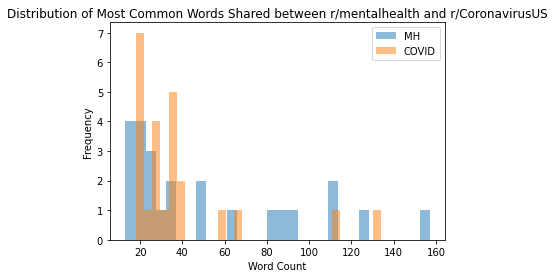

In [55]:
# Histogram of 24 most common words shared between both subreddits
plt.title('Distribution of Most Common Words Shared between r/mentalhealth and r/CoronavirusUS')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.hist(x=common_words_df['mh_word_count'],
         bins=30, alpha=0.5, label='MH')
plt.hist(x=common_words_df['covid_word_count'],
         bins=30, alpha=0.5, label='COVID')
plt.legend();

In [56]:
# change this to a ~double bar graph, to show the differences between each word as the x labels
# This histogram doesn't really tell me anything

In [60]:
# Save common_words_df to csv
common_words_df.to_csv('../data/shared_words.csv', index = False)

In [61]:
# Save cleaned posts as csv file
df.to_csv('../data/cleaned_posts.csv', index=False)

### Visualize correlation/distribution

In [ ]:
sns.pairplot(df);

There appears to be a larger distribution with regards to the number of comments attribute to a post for the r/Coronavirus subreddit (is_mental = 0) than for posts on r/mentalhealth (is_mental = 1)

In [ ]:
df.is_mental.value_counts()

In [ ]:
# Checking the title of posts in the r/mentalhealth subreddit
df.loc[df.is_mental == 1, 'title'].head(20)

In [ ]:
# Checking the title of posts in the r/Coronavirus subreddit
df.loc[df.is_mental == 0, 'title'].head(20)

Need to get rid of dollar signs, percent signs, slashes, question marks, quotations

## Preprocessing

In [ ]:
# Preprocessing function
def titles_to_words(raw_title):
    
    # Get rid of accents
    unaccented = unidecode.unidecode(raw_title)
    
    # Get rid of punctuation
    letters_only = re.sub("&[^a-zA-Z]", " ", unaccented)
    
    # Get all lowercase words
    words = letters_only.lower().split()
    
    # Instantiate and run Lemmatizer
    lemmatizer = WordNetLemmatizer()
    tokens_lem = [lemmatizer.lemmatize(i) for i in words]
    
    # Remove stop words
    stops = set(stopwords.words('english'))
    meaningful_words = [w for w in words if not w in stops]
    
    # Join into string and return the result.
    return(" ".join(meaningful_words))

In [ ]:
# Clean all titles
total_titles = df.shape[0]
clean_titles = []

print("Cleaning and parsing the titles...")

j = 0
for title in df['title']:
    # Convert to words, then append to clean_train
    clean_titles.append(titles_to_words(title))
    
    # If the index is divisible by 1000, print a message
    if (j+1) % 1000 == 0:
        print(f'Comment {j+1} of {total_titles}.')
    
    j += 1
    
    if j == total_titles:
        print('Done.')

In [ ]:
# Add cleaned titles to dataframe
df = df.assign(clean_title = clean_titles)
df.head(3)

In [ ]:
df[['num_comments', 'title', 'selftext', 'is_mental', 'clean_title', 'title_char_length', 'title_word_count']].to_csv('./data/cleaned_subreddits_1.csv')

Train/Test/Split

In [ ]:
# omitting 'uncleanned title' and 'selftext' from the features list
features = ['num_comments', 'clean_title', 'title_char_length', 'title_word_count']

I'm going to start off with a model that only uses the clean title as a feature

In [ ]:
# features and target
X = df['clean_title']
y = df['is_mental']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 42)

Baseline score

In [ ]:
y_train.value_counts(normalize=True)

This baseline score means that if a model were to predict that a post comes from r/mentalhealth subreddit, it would be correct 51% of the time. In order for a model that I develop to be considered useful, it must correctly predict that a post comes from the r/mentalhealth subreddit more than 51% of the time.

In [ ]:
X_train.head()

Fit the text data in order to be modeled

In [ ]:
vect = CountVectorizer()

# Fit the vectorizer on our corpus and transform
X_train_vect = vect.fit_transform(X_train)
X_train_vect = pd.DataFrame(X_train_vect.toarray(), columns=vect.get_feature_names())

# Transform the test set
X_test_vect = vect.transform(X_test)

In [ ]:
len(vect.get_feature_names())

In [ ]:
X_train_vect.head()

Classifcation models

In [ ]:
# Instantiate model
rf = RandomForestClassifier(random_state=42, verbose=0)
cross_val_score(rf, X_train_vect, y_train)

# Set model params for GridSearch
rf_params = {
    'n_estimators': [15, 20, 25],
    'max_depth': [20, 50, 100]
}

# Do GridSearch
gs = GridSearchCV(rf, param_grid=rf_params, cv=3)
gs.fit(X_train_vect, y_train)
print(gs.best_score_)
print(gs.best_params_)

In [ ]:
# Commenting out so this will not run every time
# Instantiate model
rf = RandomForestClassifier(max_depth = 100, n_estimators=20, random_state=42)

# Fit model
rf.fit(X_train_vect, y_train)

# Get scores
print('CV score:', cross_val_score(rf, X_train_vect, y_train, cv=3).mean())
print('Training accuracy:', rf.score(X_train_vect, y_train))
print('Testing accuracy:', rf.score(X_test_vect, y_test))

In [ ]:
# Instantiate model
logreg = LogisticRegression(solver='liblinear', penalty = "l1")

# Fit on training data.
logreg.fit(X_train_vect, y_train)

# Get scores
print('CV score:', cross_val_score(logreg, X_train_vect, y_train, cv=3).mean())
print('Training accuracy:', logreg.score(X_train_vect, y_train))
print('Testing accuracy:', logreg.score(X_test_vect, y_test))

In [ ]:
# Instantiate model
nb = MultinomialNB(.7)

# Fit model
nb.fit(X_train_vect, y_train)

# Get scores
print('CV score:', cross_val_score(nb, X_train_vect, y_train, cv=3).mean())
print('Training accuracy:', nb.score(X_train_vect, y_train))
print('Testing accuracy:', nb.score(X_test_vect, y_test))

### Evaluation of Models
**Random Forest Classifier** had the highest training accuracy

**Multinomial Naive Bayes** had the highest testing accuracy

**Logistic Regression with lasso regularization** had a testing accuracy that is closest to its training accuracy relative to the other two models, meaning that it is the least overfit model out of the three models. 

**Because of this, I'm going to create predictions using the Logistic Regression model**

In [ ]:
# Create confusion matrix
predictions = logreg.predict(X_test_vect)
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(cm, columns=['predict neg', 'predict pos'], index=['actual neg', 'actual pos'])
cm_df

In [ ]:
# Calculating classification metrics using the logistic regression model
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()

accuracy = (tp + tn) / (tp + fn + fp + tn) * 100
misclassification = (100 - accuracy)
sensitivity = tp / (tp + fn) * 100
specificity = tn / (tn + fp) * 100
precision = tp / (tp + fp) * 100

print(f'Accuracy: {round(accuracy, 2)}%')
print(f'Misclassification rate: {round(misclassification, 2)}%')
print(f'Recall / Sensitivity: {round(sensitivity, 2)}%')
print(f'Specificity: {round(specificity, 2)}%')
print(f'Precision: {round(precision, 2)}%')

The accuracy score shows that the model is correctly predicting that a post comes from the correct subreddit 94.29% of the time, and misclassifying the posts 5.71% of the time.

The precision score shows that out of all of the posts that are actually from the r/mentalhealth subreddit, the model predicted that a post came from r/mentalhealth 90.52% of the time

Out of the posts predicted to be from r/mentalhealth, the model correctly predicted these posts 98.67% of the time.

Out of the posts predicted to be from r/Coronavirus, the model correctly predicted these posts 90.1% of the time.

# Conclusion

My baseline model had an accuracy score of 51%, and my logistic regression model has an accuracy of 94.29%, showing that the logisitc regression model is significantly better at predicting the correct subreddit.

The accuracy may have been high for a few reasons - although there was a lot of talk regarding mental health on r/Coronavirus at the beginning of the pandemic, there is less discussion about mental health now. The data scraped was from the last few weeks (as of 3.9.21), and the context of the posts on r/Coronavirus has changed to discussiong related to vaccines and government policy.

In order to make the model stronger, I need to scrape older data that has more overlap with the mental health subreddit. This may help illuminate the most important features that help predict correct classification.

Moving forward, I can use the model on the US Coronavirus subreddit. There are more foum based posts on that subreddit, and it may have more overlap than the general coronavirus subreddit which contains active users from all over the world. There appears to be more similair language on the US coronavirus subreddit, and it would challenge my model more than the general Coronavirus subreddit.

I can analyze the highest occuring words from both subreddits. This would help us understand what words the model considers the most important when predicting the outcome. This could also help us understand what words are indiciative of change sin mental health incidence and prevlence, which could allow us to utilize or generalize this model to text based web content outside of the mental health subreddit.

Next steps will be using my own list of stop words, which could exlcude words such as 'coronavirus' or 'mental health'. Words will also be lemmatized.